In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from google.colab import files
import keras
from keras import Input, layers, Model, optimizers, losses, metrics

# Set random seed for reproducibility.
keras.utils.set_random_seed(42)

# Upload and load the dataset.
uploaded = files.upload()
df = pd.read_excel("schizophrenia_dataset.xlsx")
print("Dataset preview:")
print(df.head())

# Check info to verify data types and columns.
df.info()


Saving schizophrenia_dataset.xlsx to schizophrenia_dataset (1).xlsx
Dataset preview:
   Patient ID  Age  Gender  Education Level  Marital Status  Occupation  \
0           1   72       1                4               2           0   
1           2   49       1                5               2           2   
2           3   53       1                5               3           2   
3           4   67       1                3               2           0   
4           5   54       0                1               2           0   

   Income Level  Living Area  Diagnosis  Disease Duration  Hospitalizations  \
0             2            1          0                 0                 0   
1             1            0          1                35                 1   
2             1            0          1                32                 0   
3             2            0          0                 0                 0   
4             2            1          0                 0            

In [33]:
# Drop identifier column.
df = df.drop(columns=["Patient ID"])

# Separate the target ('Diagnosis') and features.
target = df["Diagnosis"]
df_features = df.drop(columns=["Diagnosis"])

# Identify continuous and categorical columns.
continuous_cols = [
    "Age",
    "Disease Duration",
    "Hospitalizations",
    "Positive Symptom Score",
    "Negative Symptom Score",
    "GAF_Score"
]
categorical_cols = [col for col in df_features.columns if col not in continuous_cols]

# Preprocess continuous variables (z‑score normalization).
df_continuous = df_features[continuous_cols]
df_continuous_normalized = (df_continuous - df_continuous.mean()) / df_continuous.std()

# Preprocess categorical variables (one‑hot encoding).
df_categorical = df_features[categorical_cols].astype(str)
df_categorical_encoded = pd.get_dummies(df_categorical, prefix=categorical_cols, drop_first=True)

# Combine processed features, and add the target back.
df_preprocessed = pd.concat([df_continuous_normalized, df_categorical_encoded], axis=1)
df_preprocessed["Diagnosis"] = target

print("\nColumns after preprocessing:")
print(df_preprocessed.columns.tolist())



Columns after preprocessing:
['Age', 'Disease Duration', 'Hospitalizations', 'Positive Symptom Score', 'Negative Symptom Score', 'GAF_Score', 'Gender_1', 'Education Level_2', 'Education Level_3', 'Education Level_4', 'Education Level_5', 'Marital Status_1', 'Marital Status_2', 'Marital Status_3', 'Occupation_1', 'Occupation_2', 'Occupation_3', 'Income Level_1', 'Income Level_2', 'Living Area_1', 'Family History_1', 'Substance Abuse_1', 'Suicide Attempt_1', 'Social Support_1', 'Social Support_2', 'Stress Factors_1', 'Stress Factors_2', 'Medication Adherence_1', 'Medication Adherence_2', 'Diagnosis']


In [34]:
# Split the dataset into train (80%), validation (10%), and test (10%).
train_df, temp_df = train_test_split(df_preprocessed, test_size=0.2, random_state=100, stratify=df_preprocessed["Diagnosis"])
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=100, stratify=temp_df["Diagnosis"])

print("\nTraining sample:")
print(train_df.head())
print("\nTest sample:")
print(test_df.head())

# Separate features and labels.
label_column = "Diagnosis"
train_features = train_df.drop(columns=[label_column])
train_labels = train_df[label_column].to_numpy()

validation_features = validation_df.drop(columns=[label_column])
validation_labels = validation_df[label_column].to_numpy()

test_features = test_df.drop(columns=[label_column])
test_labels = test_df[label_column].to_numpy()



Training sample:
           Age  Disease Duration  Hospitalizations  Positive Symptom Score  \
7798  1.324855         -0.529421         -0.509994               -0.770577   
9792 -0.816231         -0.529421         -0.509994               -0.477289   
3196  0.391561         -0.439060          1.614538                0.879167   
6069 -1.365228         -0.529421         -0.509994               -0.330645   
2412  1.654253         -0.529421         -0.509994               -0.990543   

      Negative Symptom Score  GAF_Score  Gender_1  Education Level_2  \
7798               -0.091104   0.415345      True               True   
9792               -1.090456  -0.084659      True              False   
3196                0.427079  -2.334675      True              False   
6069               -0.868378   0.665346     False               True   
2412                0.316040   0.207010     False               True   

      Education Level_3  Education Level_4  ...  Family History_1  \
7798       

In [35]:
def create_model(input_feature_names, learning_rate, classification_threshold):
    """
    Create and compile a simple logistic regression model.
    """
    # Create one input for each feature.
    model_inputs = [Input(name=name, shape=(1,)) for name in input_feature_names]
    concatenated_inputs = layers.Concatenate()(model_inputs)
    output = layers.Dense(units=1, activation="sigmoid")(concatenated_inputs)
    model = Model(inputs=model_inputs, outputs=output)

    # Compile the model with binary cross-entropy loss.
    model.compile(
        optimizer=optimizers.RMSprop(learning_rate),
        loss=losses.BinaryCrossentropy(),
        metrics=[
            metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
            metrics.Precision(name='precision', thresholds=classification_threshold),
            metrics.Recall(name='recall', thresholds=classification_threshold),
            metrics.AUC(num_thresholds=100, name='auc')
        ]
    )
    return model

def prepare_features(dataset, feature_names):
    """
    Given a DataFrame, prepare a dictionary mapping each feature input name to its numpy array.
    """
    return {feature: np.array(dataset[feature]) for feature in feature_names}

# Check available column names.
print("\nColumns in train_features:")
print(train_features.columns.tolist())

# Define baseline features.
# NOTE: Update the feature names if needed—the one-hot encoded columns (e.g., "Family History" might become "Family History_1").
input_features_baseline = [
    "Positive Symptom Score",
    "Family History_1",   # Ensure this exactly matches one of the columns from pd.get_dummies().
    "Age"
]



Columns in train_features:
['Age', 'Disease Duration', 'Hospitalizations', 'Positive Symptom Score', 'Negative Symptom Score', 'GAF_Score', 'Gender_1', 'Education Level_2', 'Education Level_3', 'Education Level_4', 'Education Level_5', 'Marital Status_1', 'Marital Status_2', 'Marital Status_3', 'Occupation_1', 'Occupation_2', 'Occupation_3', 'Income Level_1', 'Income Level_2', 'Living Area_1', 'Family History_1', 'Substance Abuse_1', 'Suicide Attempt_1', 'Social Support_1', 'Social Support_2', 'Stress Factors_1', 'Stress Factors_2', 'Medication Adherence_1', 'Medication Adherence_2']


In [36]:
print("Columns in train_features:", train_features.columns.tolist())


Columns in train_features: ['Age', 'Disease Duration', 'Hospitalizations', 'Positive Symptom Score', 'Negative Symptom Score', 'GAF_Score', 'Gender_1', 'Education Level_2', 'Education Level_3', 'Education Level_4', 'Education Level_5', 'Marital Status_1', 'Marital Status_2', 'Marital Status_3', 'Occupation_1', 'Occupation_2', 'Occupation_3', 'Income Level_1', 'Income Level_2', 'Living Area_1', 'Family History_1', 'Substance Abuse_1', 'Suicide Attempt_1', 'Social Support_1', 'Social Support_2', 'Stress Factors_1', 'Stress Factors_2', 'Medication Adherence_1', 'Medication Adherence_2']



--- Fold 1 ---
Fold 1 evaluation (loss, accuracy, precision, recall, AUC): [0.07370442152023315, 0.9900000095367432, 0.9710744023323059, 0.9957627058029175, 0.9997586011886597]

--- Fold 2 ---
Fold 2 evaluation (loss, accuracy, precision, recall, AUC): [0.09777297079563141, 0.9762499928474426, 0.942148745059967, 0.9785407781600952, 0.9988834857940674]

--- Fold 3 ---
Fold 3 evaluation (loss, accuracy, precision, recall, AUC): [0.0887865349650383, 0.9856250286102295, 0.9670329689979553, 0.9821428656578064, 0.9993422031402588]

--- Fold 4 ---
Fold 4 evaluation (loss, accuracy, precision, recall, AUC): [0.13331036269664764, 0.9781249761581421, 0.949367105960846, 0.9761388301849365, 0.9986621141433716]

--- Fold 5 ---
Fold 5 evaluation (loss, accuracy, precision, recall, AUC): [0.07961360365152359, 0.9868749976158142, 0.9662446975708008, 0.9892008900642395, 0.9995744824409485]

Average evaluation metrics across folds (loss, accuracy, precision, recall, AUC):
[0.09463758 0.983375   0.95917

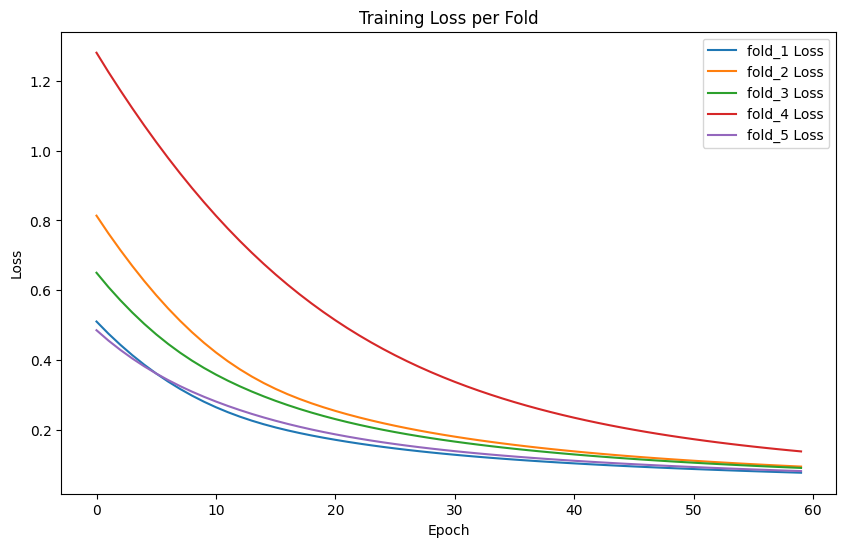

In [40]:
# Set up K-Fold cross-validation (5 folds).
kf = KFold(n_splits=5, shuffle=True, random_state=100)
fold_metrics = []      # To store evaluation metrics (loss, accuracy, precision, recall, AUC) for each fold.
fold_histories = {}    # To store history for plotting training loss curves.

baseline_settings = {
    "learning_rate": 0.001,
    "epochs": 60,
    "batch_size": 100,
    "classification_threshold": 0.35
}

fold_idx = 1
for train_index, val_index in kf.split(train_features):
    print(f"\n--- Fold {fold_idx} ---")

    # Create folds.
    X_train_fold = train_features.iloc[train_index]
    y_train_fold = train_labels[train_index]
    X_val_fold = train_features.iloc[val_index]
    y_val_fold = train_labels[val_index]

    # Prepare input dictionaries.
    fold_train_inputs = prepare_features(X_train_fold, input_features_baseline)
    fold_val_inputs = prepare_features(X_val_fold, input_features_baseline)

    # Create and train the model for the current fold.
    model_fold = create_model(
        input_feature_names=input_features_baseline,
        learning_rate=baseline_settings["learning_rate"],
        classification_threshold=baseline_settings["classification_threshold"]
    )

    history = model_fold.fit(
        x=fold_train_inputs,
        y=y_train_fold,
        validation_data=(fold_val_inputs, y_val_fold),
        batch_size=baseline_settings["batch_size"],
        epochs=baseline_settings["epochs"],
        verbose=0
    )

    # Evaluate the fold's model on its validation set.
    fold_eval = model_fold.evaluate(x=fold_val_inputs, y=y_val_fold, verbose=0)
    print(f"Fold {fold_idx} evaluation (loss, accuracy, precision, recall, AUC): {fold_eval}")

    fold_metrics.append(fold_eval)
    fold_histories[f"fold_{fold_idx}"] = history.history
    fold_idx += 1

# Compute and print the average metrics across folds.
avg_metrics = np.mean(fold_metrics, axis=0)
print("\nAverage evaluation metrics across folds (loss, accuracy, precision, recall, AUC):")
print(avg_metrics)

# Visualize metrics across folds with bar plots.
fold_numbers = np.arange(1, 6)
accuracies = [metrics[1] for metrics in fold_metrics]  # accuracy at index 1
precisions = [metrics[2] for metrics in fold_metrics]  # precision at index 2
recalls = [metrics[3] for metrics in fold_metrics]     # recall at index 3
auc_scores = [metrics[4] for metrics in fold_metrics]    # AUC at index 4


# Plot training loss curves for each fold.
plt.figure(figsize=(10, 6))
for fold, history in fold_histories.items():
    plt.plot(history['loss'], label=f"{fold} Loss")
plt.title("Training Loss per Fold")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [38]:
# For final evaluation, combine training and validation sets.
final_train_df = pd.concat([train_df, validation_df])
final_train_features = final_train_df.drop(columns=[label_column])
final_train_labels = final_train_df[label_column].to_numpy()

# Create and train the final model.
final_model = create_model(
    input_feature_names=input_features_baseline,
    learning_rate=baseline_settings["learning_rate"],
    classification_threshold=baseline_settings["classification_threshold"]
)
final_train_inputs = prepare_features(final_train_features, input_features_baseline)
final_model.fit(
    x=final_train_inputs,
    y=final_train_labels,
    batch_size=baseline_settings["batch_size"],
    epochs=baseline_settings["epochs"],
    verbose=0
)

# Evaluate the final model on the test set.
test_inputs = prepare_features(test_features, input_features_baseline)
test_eval = final_model.evaluate(x=test_inputs, y=test_labels, verbose=0)
print("\nFinal model evaluation on test set (loss, accuracy, precision, recall, AUC):")
print(test_eval)



Final model evaluation on test set (loss, accuracy, precision, recall, AUC):
[0.05102625861763954, 0.9869999885559082, 0.9629629850387573, 0.9930555820465088, 0.9997830390930176]


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Confusion Matrix:
[[701  11]
 [  2 286]]


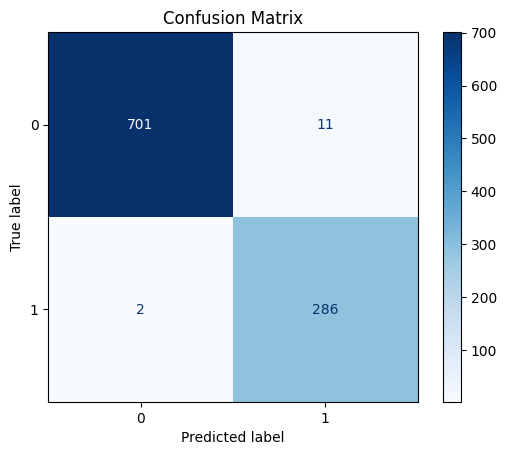


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       712
           1       0.96      0.99      0.98       288

    accuracy                           0.99      1000
   macro avg       0.98      0.99      0.98      1000
weighted avg       0.99      0.99      0.99      1000



In [39]:
# Generate predictions on the test set.
y_pred_prob = final_model.predict(test_inputs)
y_pred = (y_pred_prob > baseline_settings["classification_threshold"]).astype(int)

# Compute and display the confusion matrix.
cm = confusion_matrix(test_labels, y_pred)
print("\nConfusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Print the classification report.
print("\nClassification Report:")
print(classification_report(test_labels, y_pred))
